In [43]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [4]:
df = pd.read_csv("final_named_data.csv", index_col='id')
df.head()

,Unnamed: 0,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,76,77,78,81,84,85,86,87,88,name
id,,,,,,,,,,,,,,,,,,,,,
1,0,15943882.0,63,1,NaN,NaN,NaN,NaN,1.0,145.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
2,1,15964847.0,67,1,NaN,NaN,NaN,NaN,4.0,160.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
3,2,15952199.0,67,1,NaN,NaN,NaN,NaN,4.0,120.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
4,3,15929464.0,37,1,NaN,NaN,NaN,NaN,3.0,130.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
6,4,11961207.0,41,0,NaN,NaN,NaN,NaN,2.0,130.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name


In [10]:
df = df.drop(['Unnamed: 0', 'name'], axis=1)

In [ ]:
# if not smoke -> cigs=0
# if cigs=0 -> smoke=0
# if cigs != 0 -> smoke = 1
df.loc[df['smoke']==0, 'cigs'] = 0
df.loc[df['cigs']==0, 'smoke'] = 0
df.loc[(df['cigs']!=0) & (df['cigs'].notna()), 'smoke'] = 1

### Remove rows and columns with too many missing values

In [ ]:
def clean_data(df, max_missing_ratio_row, max_missing_ratio_column):
    
    missing_ratio_per_row = df.isna().mean(axis=1)
    df_cleaned_rows = df[missing_ratio_per_row < max_missing_ratio_row]

    missing_ratio_per_column = df_cleaned_rows.isna().mean(axis=0)
    df_cleaned = df_cleaned_rows.loc[:, missing_ratio_per_column < max_missing_ratio_column]

    return df_cleaned

max_missing_ratio_row = 0.5
max_missing_ratio_column = 0.5
df_cleaned = clean_data(df, max_missing_ratio_row, max_missing_ratio_column)
df_cleaned.shape

(1347, 62)

In [ ]:
df_cleaned.head()

,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,...,lvx1,lvx2,lvx3,lvx4,lvf,75,85,86,87,88
id,,,,,,,,,,,,,,,,,,,,,
1,15943882.0,63,1,NaN,NaN,NaN,NaN,1.0,145.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,15964847.0,67,1,NaN,NaN,NaN,NaN,4.0,160.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,15952199.0,67,1,NaN,NaN,NaN,NaN,4.0,120.0,1.0,...,1.0,1.0,1.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0
4,15929464.0,37,1,NaN,NaN,NaN,NaN,3.0,130.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,11961207.0,41,0,NaN,NaN,NaN,NaN,2.0,130.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_cleaned.to_csv("final_named_and_cleaned_data_0_5.csv")

In [ ]:
X = df_cleaned.drop(columns=['num'])
y = df_cleaned['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Dealing with imbalance

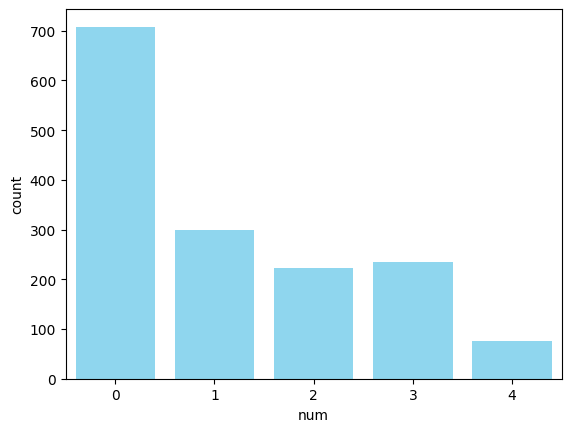

In [40]:
sns.countplot(x=df['num'], color='deepskyblue', alpha=0.5)
plt.show()

In [46]:
# najpierw nany usunąć :)
# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)
# print(X_smote.shape)
# for i in df_cleaned['num'].unique():
#     print(f"Class {i}: {y_smote.value_counts()[i]} samples")

## Modeling

### Random Forest 

In [27]:
rf = RandomForestClassifier(random_state=42)

grid_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, grid_params, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Najlepsze hiperparametry dla RandomForestClassifier: {best_params}")

Najlepsze hiperparametry dla RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [30]:
best_rf = grid_search.best_estimator_
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

Classification report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       103
           1       0.85      0.69      0.76        68
           2       0.73      0.63      0.67        51
           3       0.69      0.81      0.74        36
           4       1.00      0.83      0.91        12

    accuracy                           0.82       270
   macro avg       0.83      0.79      0.80       270
weighted avg       0.82      0.82      0.81       270



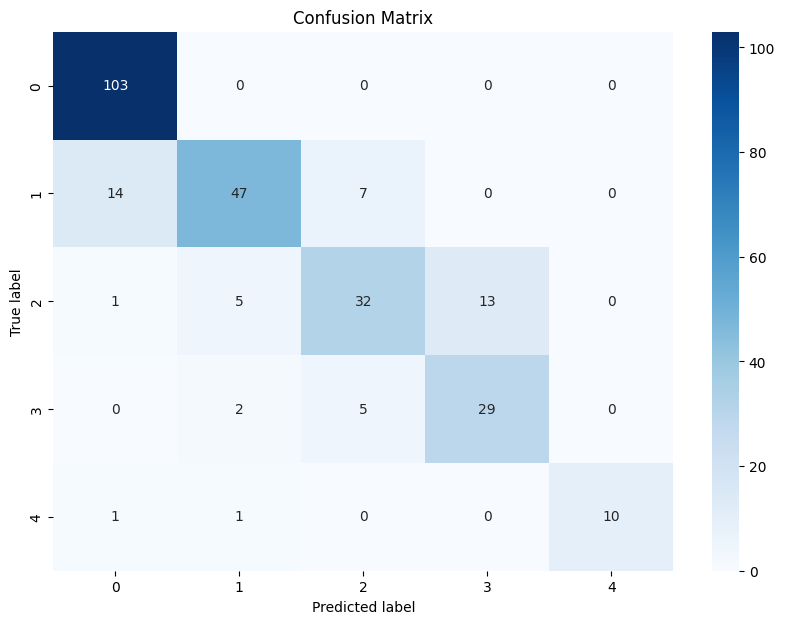

In [36]:
with open('random_forest_model.pkl', 'rb') as f:
    best_rf = pickle.load(f)

y_pred = best_rf.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()